In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


import random

In [6]:
def train_test_split(df, age, test_size=0.3):
    all_numbers = set(range(int(len(df)/10)))
    random_numbers = random.sample(sorted(all_numbers), int(len(df)/10*test_size))
    #all_numbers -= set(random_numbers)  # 從所有數字中移除已經選取的數字
    
    X_test = pd.DataFrame()
    y_test = pd.Series(dtype='int')
    for i in random_numbers:
        X_test = pd.concat([X_test, df.iloc[i*10:i*10+10]])
        y_test = pd.concat([y_test, age.iloc[i*10:i*10+10]])
        df = df.drop(df.index[i*10: i*10+10])
        age = age.drop(age.index[i*10: i*10+10])
    
    X_train = df
    y_train = age
    
    
    return X_train, X_test, y_train, y_test, random_numbers

def XGBR(X_train, X_test, y_train, y_test, n_estimators, max_depth, savefig):
    # n_jobs=-1處理器全開
    xgbrModel = xgb.XGBRegressor(n_estimators = n_estimators, n_jobs=-1, max_depth = max_depth, learning_rate=0.2, 
                                colsample_bytree = 1, gamma = 0.1, min_child_weight = 1,rate_drop=0.1, skip_drop=0.5, booster='dart',
                                subsample = 0.8, eval_metric="rmse", reg_alpha=0.1, reg_lambda=0.1)  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model with early stopping
    eval_set = [(X_test, y_test)]
    xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    y_pred = xgbrModel.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',xgbrModel.score(X_train,y_train))
    print('Test Set score: ',xgbrModel.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.xlabel('Chronological Age',fontsize = 16)
    plt.ylabel('Predicted Age',fontsize = 16)
    plt.title('Healthy',fontsize = 18)
    plt.savefig(f"model_result\\{savefig}.png", dpi=300, bbox_inches='tight')
    plt.show()
   
    print('特徵重要程度: ',xgbrModel.feature_importances_)
    
    return xgbrModel

def xgbr_gridsearch(X_train, X_test, y_train, y_test, param_grid):
    # 創建模型
    xgbrModel = xgb.XGBRegressor(n_jobs=-1)

    # 創建GridSearchCV對象
    grid_search = GridSearchCV(estimator=xgbrModel, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

    # 開始搜索
    grid_search.fit(X_train, y_train)

    # 打印最佳參數
    print('Best parameters found: ', grid_search.best_params_)

    # 使用最佳參數創建新的模型
    best_xgbrModel = grid_search.best_estimator_

    # 使用新的模型進行預測
    y_pred = best_xgbrModel.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',best_xgbrModel.score(X_train,y_train))
    print('Test Set score: ',best_xgbrModel.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.xlabel('Chronological Age',fontsize = 16)
    plt.ylabel('Predicted Age',fontsize = 16)
    plt.title('Healthy',fontsize = 18)
    #plt.savefig(f"model_result\\{savefig}.png", dpi=300, bbox_inches='tight')
    plt.show()
   
    print('特徵重要程度: ',best_xgbrModel.feature_importances_)
    
    return xgbrModel
    
# 定義要搜索的參數
param_grid = {
    'n_estimators': [15, 20, 25, 30, 35, 40, 45],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.1, 0.2],
    'colsample_bytree': [0.3, 0.4, 0.5],
    'gamma': [0.1, 0.2, 0.3],
    'min_child_weight': [1, 2],
    'rate_drop': [0.1, 0.2],
    'skip_drop': [0.5],
    'booster': ['dart'],
    'subsample': [0.3, 0.4, 0.5, 0.6],
    'eval_metric': ['rmse'],
    'reg_alpha': [0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 0.2, 0.3]
}

In [3]:
with open("data_augmentation_GSE174188_intersection_with_GSE165080_GSE149689_GSE227991.csv", 'r') as file:
    df_data_augmentation = pd.read_csv(file, index_col = 0)
with open("mean_and_stdev_GSE174188_intersection_with_GSE165080_GSE149689_GSE227991.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
age_data_augmentation = df_data_augmentation["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df_data_augmentation = df_data_augmentation.drop(columns = "age", axis = 1)

X_train, X_test_data_augmentation, y_train, y_test_data_augmentation , random_numbers= train_test_split(df_data_augmentation, age_data_augmentation, 0.3)

age = df["age"].astype(int)
df = df.drop(columns = "age", axis = 1)

X_test = pd.DataFrame()
y_test = pd.Series()
X_test = pd.concat([X_test, df.iloc[random_numbers]])
y_test = pd.concat([y_test, pd.Series(age.iloc[random_numbers])])

C:\Users\benson\AppData\Local\Temp\ipykernel_341988\2321263589.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test = pd.Series()


Best parameters found:  {'booster': 'dart', 'colsample_bytree': 0.4, 'eval_metric': 'rmse', 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 15, 'rate_drop': 0.2, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'skip_drop': 0.5, 'subsample': 0.3}
Mean Squared Error (MSE): 344.6321946243013
Mean Absolute Error (MAE): 18.541390171757453
Train Set score:  0.24663386819224042
Test Set score:  -409.51776124365296
Pearson correlation: 0.2366917471889275


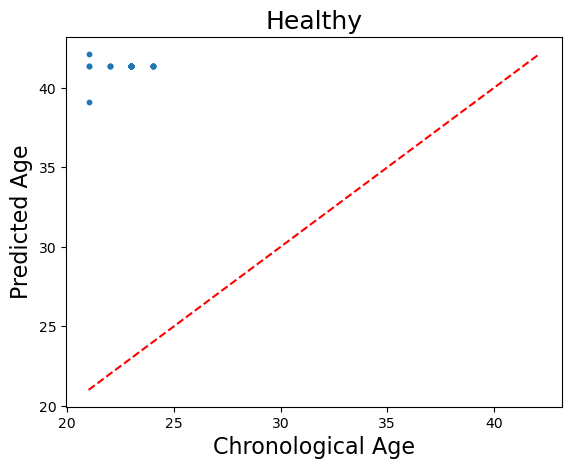

特徵重要程度:  [0.15880485 0.07647938 0.12960957 0.15064152 0.09235446 0.1530866
 0.07858036 0.0099833  0.02229739 0.04065672 0.         0.08750585]


NotFittedError: need to call fit or load_model beforehand

In [7]:
xgbrModel = xgbr_gridsearch(X_train, X_test, y_train, y_test, param_grid)

from xgboost import plot_importance
plot_importance(xgbrModel)

In [ ]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, 45, 4, 'GSE174188_Healthy_XGBR')

from xgboost import plot_importance
plot_importance(xgbrModel)
plt.savefig("model_result/GSE174188_Healthy_XGBR_importance_features.png", dpi=300, bbox_inches='tight')

In [ ]:
#X_train, X_test, y_train, y_test , random_numbers= train_test_split(df_data_augmentation, age_data_augmentation, 0.3)
xgbrModel = XGBR(X_train, X_test_data_augmentation, y_train, y_test_data_augmentation, 45, 4, 'GSE174188_Healthy_XGBR_data_augmentation')

from xgboost import plot_importance
plot_importance(xgbrModel)
plt.savefig("model_result/GSE174188_Healthy_XGBR_data_augmentation_importance_features.png", dpi=300, bbox_inches='tight')

# GSE165080+GSE149689+GSE227991

In [ ]:
with open("data_augmentation_GSE165080_GSE149689_GSE227991_gene_intersection_with_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

In [ ]:
X_train, X_test, y_train, y_test , random_numbers= train_test_split(df, age, 0.3)
xgbrModel = XGBR(X_train, X_test, y_train, y_test, 30, 4, "GSE165080_GSE149689_GSE227991_XGBR_data_augmentation")

from xgboost import plot_importance
plot_importance(xgbrModel)
plt.savefig("model_result/GSE165080_GSE149689_GSE227991_XGBR_data_augmentation_importance_features.png", dpi=300, bbox_inches='tight')

# GSE174188

In [ ]:
with open("data_augmentation_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
age = df["age"].astype(int)
df = df.drop(columns = "age", axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, age, 0.3)

In [ ]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, 45, 4)

In [ ]:
with open("data_augmentation_GSE174188_SLE.csv", 'r') as file:
    df_SLE = pd.read_csv(file, index_col = 0)
age_SLE = df_SLE["age"].astype(int)
df_SLE = df_SLE.drop(columns = "age", axis = 1)

In [ ]:
validation_result(xgbrModel, df_SLE, age_SLE)

# GSE165080 + GSE149689(BBKNN + Azimuth)

In [ ]:
with open("data_augmentation_merge(GSE165080,GSE149689).csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
with open('data_augmentation_GSE149689.csv', 'r') as file:
    df_GSE149689 = pd.read_csv(file, index_col = 0)
    
age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

age_GSE149689 = df_GSE149689['age'].astype(int)
df_GSE149689 = df_GSE149689.drop(columns = 'age', axis = 1)
#df = df.drop(df_GSE149689.index)
#age = age.drop(age_GSE149689.index)

In [ ]:
set(age)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, age, 0.3)

In [ ]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, 45, 4)

# GSE165080 + GSE149689(BBKNN)

In [ ]:
with open("data_augmentation_merge(GSE165080,GSE149689).csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
with open('data_augmentation_GSE149689.csv', 'r') as file:
    df_GSE149689 = pd.read_csv(file, index_col = 0)
    
age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

age_GSE149689 = df_GSE149689['age'].astype(int)
df_GSE149689 = df_GSE149689.drop(columns = 'age', axis = 1)
df = df.drop(df_GSE149689.index)
age = age.drop(age_GSE149689.index)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, age, 0.3)

In [ ]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689)", 45, 4)

# GSE165080 + GSE149689(Azimuth + BBKNN)

In [ ]:
with open("data_augmentation_combine_GSE165080_GSE149689.csv", "r") as file:
    df = pd.read_csv(file, index_col = 0)
with open('data_augmentation_GSE149689.csv', 'r') as file:
    df_GSE149689 = pd.read_csv(file, index_col = 0)
    
age = df['age'].astype(int)
df = df.drop(columns = 'age', axis = 1)

age_GSE149689 = df_GSE149689['age'].astype(int)
df_GSE149689 = df_GSE149689.drop(columns = 'age', axis = 1)
#df = df.drop(df_GSE149689.index)
#age = age.drop(age_GSE149689.index)

X_train, X_test, y_train, y_test = train_test_split(df, age, 0.3)

In [ ]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689)", 45, 8)

In [ ]:
from xgboost import plot_importance
plot_importance(xgbrModel)

In [ ]:
validation_result(xgbrModel, df_GSE149689, age_GSE149689, "Merge(GSE165080,GSE149689)")

In [ ]:
lr = LR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689)")

# GSE165080 + GSE149689 + GSE174188(BBKNN)

Train >> GSE174188

Test >> GSE174188

Validation >> GSE165080 + GSE149689

In [ ]:
with open("data_augmentation_merge(GSE165080,GSE149689,GSE174188).csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
with open("data_augmentation_combine_GSE165080_GSE149689.csv", 'r') as file:
    df_two_dataset = pd.read_csv(file, index_col = 0)
age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

#df = df.drop(df_two_dataset.index)
#age = age.drop(df_two_dataset["age"].index)
age_two_dataset = df_two_dataset["age"].astype(int)
df_two_dataset = df_two_dataset.drop(columns = 'age', axis=1)

In [ ]:
df

In [ ]:
#X_train, X_test, y_train, y_test, X_validation, y_validation= train_test_validation_split(df, age, 0.3, 0.1)

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(df, age, 0.2)
xgbrModel = XGBR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689,GSE174188)", 45, 4) 

In [ ]:
from xgboost import plot_importance
plot_importance(xgbrModel)

In [ ]:
def RandomForestRegression(X_train, X_test, y_train, y_test, title, n_estimators=45):
    # n_jobs=-1處理器全開
    RFR = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)# , random_state=0
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)
    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(RFR, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model
    RFR.fit(X_train, y_train)

    y_pred = RFR.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',RFR.score(X_train,y_train))
    print('Test Set score: ',RFR.score(X_test,y_test))

    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')

    plt.scatter(y_test, y_pred, s=10, label='True')
    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    
    plt.suptitle(title)
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線
    plt.xlabel('Actual Ages',fontsize = 14)
    plt.ylabel('Predicted Ages',fontsize = 14)
    plt.title('Actual vs Predicted Ages',fontsize = 16)
    plt.show()
    
    
    print('特徵重要程度: ',RFR.feature_importances_)
    return RFR

# Linear Regression
def LR(X_train, X_test, y_train, y_test, title):
    # n_jobs=-1處理器全開
    model = LinearRegression(fit_intercept=True, n_jobs=-1)  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(model, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)


    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',model.score(X_train,y_train))
    print('Test Set score: ',model.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.suptitle(title)
    plt.xlabel('Actual Ages',fontsize = 14)
    plt.ylabel('Predicted Ages',fontsize = 14)
    plt.title('Actual vs Predicted Ages',fontsize = 16)
    plt.savefig("Healthy_XGBR.png", dpi=900)
    plt.show()
    
   
    print('特徵係數: ',model.coef_)
    
def validation_result(model, X_validation, y_validation):
    #Validataion
    y_pred_valid = model.predict(X_validation)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse_valid = mean_squared_error(y_validation, y_pred_valid)
    print(f'Mean Squared Error (MSE): {mse_valid}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae_valid = mean_absolute_error(y_validation, y_pred_valid)
    print(f'Mean Absolute Error (MAE): {mae_valid}')

    print('Validataion Set score: ',model.score(X_validation,y_validation))

    # 計算皮爾森相關係數
    corr_valid, _ = pearsonr(y_validation, y_pred_valid)
    print(f'Pearson correlation: {corr_valid}')
    plt.scatter(y_validation, y_pred_valid, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_validation), np.min(y_pred_valid)])  # 找到最小值
    max_val = np.max([np.max(y_validation), np.max(y_pred_valid)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.xlabel('Chronological Age',fontsize = 16)
    plt.ylabel('Predicted Age',fontsize = 16)
    plt.title('GSE174188_Healthy',fontsize = 18)
    #plt.savefig("SLE_XGBR.png", dpi=900, bbox_inches='tight')
    plt.show()